# Create training data from rasters and polgyons

This script takes input rasters and polygons, outomatically calculates overlap and gathers sample points. The gathered data is converted into a .csv file that can easilyt be used in any type of ML algorithm. 

## Predefined raster and shapes

In [1]:
# load libraries

# gbdx
from gbdxtools import Interface
gbdx = Interface()

# geo data tools
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.geometry import Point
from shapely.geometry import shape

import scipy.spatial as spatial

from scipy.spatial import distance

import fiona

import rasterio

import pyproj
from shapely.ops import transform
from functools import partial

# data tools
import pandas as pd
import numpy as np
from numpy import random

import glob
import os
from pprint import pprint

import random

#visualization tools
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from rasterio.plot import show

import matplotlib as mpl
from descartes import PolygonPatch

In [48]:
# define functions

def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

def random_points_within(poly, n_points_per_sqm):
    min_x, min_y, max_x, max_y = poly.bounds
    
    epsg = wgs2epsgzone(max_x, max_y)
    
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:%i'  % (epsg)))


    poly_wgs = transform(project, poly)
    
    n_points = int((poly_wgs.area / 1e6) * n_points_per_sqm)
    
    if n_points > 10000:
        n_points = 10000
    
    if n_points < 10:
        n_points = 50
    
#     print('area ' + str(poly_wgs.area))
#     print('n_points ' + str(n_points))

    points = []

    while len(points) < n_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points


def get_values_for_points(dataset, points):

    bands_save = []
    x_save = []
    y_save = []
    
    data_array = dataset.read()

    for i in range(len(points)):
        x = points[i].x
        y = points[i].y

        x_save.append(x)
        y_save.append(y)

        index = dataset.index(x, y)

        try: 
            band_values = data_array[:,index[0],index[1]]
            bands_save.append(band_values)
        except:
            # print('point ' + str(i) + ' out of image')
            continue

#         print(band_values)
        
    return bands_save, x_save, y_save
 
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

def get_closest_image_polygons(polygons, image_locations):


    x = [Multi.centroid.x for Multi in polygons]
    y = [Multi.centroid.y for Multi in polygons]

    polygon_centroids = np.array([x,y])

    polygon_centroids = polygon_centroids.T.reshape(len(x),2)

    df_polygon_image = np.zeros([len(polygon_centroids),2])

    for i in tqdm(range(len(polygon_centroids))):
        x,y = polygon_centroids[i]
        some_pt = (x, y);
        closest_index = closest_node(some_pt, image_locations)

        closest_pt = image_locations[closest_index]

        df_polygon_image[i,0] = int(i)

        df_polygon_image[i,1] = int(closest_index)
    
    df_polygon_image = pd.DataFrame(df_polygon_image, columns = ['polygon_id' , 'image_path_id'], dtype = int)
        
    return df_polygon_image

def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    rgb[rgb > 255] = 225
    

    return rgb

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list


def raster_path_list2image_centroid_coordinate(raster_path_list):
    
    image_locations = np.zeros([len(raster_path_list), 2])

    i = 0

    for path in tqdm(raster_path_list):

        dataset = rasterio.open(path)

        # get info from filenames
        stringlist = path.split('/')[-1].split('_')
        seq_nr = stringlist[1]
        image_id = stringlist[-1].split('.')[0]
        city = stringlist[0]

        # calculate center of image 
        left, bottom, right, top = dataset.bounds
        x_center = (left + right) / 2
        y_center = (top + bottom) / 2

        image_locations[i,0] = x_center
        image_locations[i,1] = y_center


        i = 1 + i
    
    return image_locations

def polygon_raster_overlap(poly, n_closest, raster_files):
    
    for n in n_closest:     

        # load raster data
        dataset = rasterio.open(raster_files[n])

        # convert bounds to polygon
        left, bottom, right, top = dataset.bounds
        polygon = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])

        # calculate overlap fraction
        overlap_area = round(poly.intersection(polygon).area / poly.area, 2)

        if overlap_area == 1:
            break  
    
    return n

def get_data_raster_polygons(class_MultiPolygon, variables, image_locations, raster_files, plotting_overlap = False):
    
    nr_of_polygons = len(class_MultiPolygon)

    # create dataframe with all variables + label
    variables_str_list= variables + ['label']
    df_subsample = pd.DataFrame(columns = variables_str_list)

    # len(df_polygon_image_id)
    for i in tqdm(range(nr_of_polygons)):

        # select polygon
        poly = class_MultiPolygon[i]

        # get polygon location as shapely obj.
        [x,y] = poly.centroid.xy
        point = np.array([x[0],y[0]])

        # get index of closest 5 images to polygon
        n_closest = distance.cdist([point], image_locations).argsort()[0,0:5]

        # check overlap for each image agianst the polygon
        n_maxoverlap = polygon_raster_overlap(poly, n_closest, raster_files)

        # get raster corresponding to polygon
        path_match_image = raster_files[n_maxoverlap]
        
        # create random samples in polygon
        samples = random_points_within(poly, n_points_per_sqkm)
        
        df = pd.DataFrame(np.zeros([len(samples),len(variables)]),  columns = variables)

        # get band values for random samples
        dataset = rasterio.open(path_match_image)
        bands_save, x_save, y_save = get_values_for_points(dataset, samples)

        # visualize training data selection
        try: 
            if plotting_overlap:
                # clear_output(wait = True)

                # get boundary xy coordinates for plotting
                try:       
                    if len(poly.boundary) == 1:
                        x,y = poly.boundary.xy
                    else:
                        n_largest = np.array([boundary.length for boundary in poly.boundary]).argmax()
                        x,y = poly.boundary[n_largest].xy
                except: 
                    x,y = poly.boundary.xy                

                data = dataset.read()
                data = data - np.min(data)
                data = data / np.maximum(np.max(data), 1) + 0.3

                plt.figure(figsize = (10,10))
                plt.plot(x,y, color = 'w')
                for point in samples:
                    plt.scatter(point.x,point.y, c = 'red', marker = '.')
                show(data[[1,3,4],:,:], transform=dataset.transform)
        except Exception as e:
            print('failed')
            print('poly nr: ', i, ' image: ', path_match_image)
            print(e)
            print('___________________________________________\n')

        # plt.show()

        try:
            df.loc[:,0:8] = bands_save
            # print('data', start_row, end_row)
        except: 
            print('no data', path_match_image)
            continue

        # get image_id from filename
        stringlist = path_match_image.split('/')[-1].split('_')
        image_id = stringlist[-1].split('.')[0]

        # get metadata 
        record = gbdx.catalog.get(image_id)
        df.loc[:,'x'] = x_save
        df.loc[:,'y'] = y_save

        for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]    
                df[property_name] = property_record
            except: 
                print('failed ', property_name, image_id)
                df[property_name] = None

        df['label'] = label

        df_subsample = df_subsample.append(df, ignore_index=True)
    
    return df_subsample


# things



In [20]:
# select variables
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

variables = [0, 1, 2, 3, 4, 5, 6, 7, 'x', 'y'] + property_names
variables

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 'x',
 'y',
 'cloudCover',
 'multiResolution',
 'targetAzimuth',
 'sunAzimuth',
 'offNadirAngle',
 'sunElevation',
 'panResolution']

In [21]:
# find all files in folders for specific classes
# find current working directory 
cwd = os.getcwd()

# define paths with training data polygons
class1_shapes_path = '../../data/shapefiles_waterbodies_osm/*water/*.shp'
class2_shapes_path = '../../data/shapefiles_waterbodies_osm/hand_cloud/*.shp'
# define paths with raster data
rasters_file_path = '../../data/rasters_waterbodies_osm/**/*.tif'

# find files in shapefile folder
class1_shape_files = glob.glob(class1_shapes_path)
class2_shape_files = glob.glob(class2_shapes_path)
# find files in raster folder
raster_files = glob.glob(rasters_file_path)

In [22]:
class1_shape_files

['../../data/shapefiles_waterbodies_osm/hand_water/hand_water.shp',
 '../../data/shapefiles_waterbodies_osm/hand_nonwater/hand_nonwater.shp']

In [23]:
class2_shape_files

['../../data/shapefiles_waterbodies_osm/hand_cloud/hand_cloud.shp']

In [24]:
from shapely.ops import cascaded_union

In [25]:
# convert esri shapefiles to shapely objects

# check valid geometries
class1_valid_shape_list = check_valid_geometries(class1_shape_files[0])
class2_valid_shape_list = check_valid_geometries(class2_shape_files[0])

# convert list to shapely MultiPolgyons
class1_MultiPoly = cascaded_union([shape(pol['geometry']) for pol in class1_valid_shape_list])
class2_MultiPoly = cascaded_union([shape(pol['geometry']) for pol in class2_valid_shape_list])

# match number of polygons to use
class1_MultiPoly = list(pd.DataFrame(class1_MultiPoly).sample(30)[0])

print('number of polygons class 1: ', len(class1_MultiPoly))
print('number of polygons class 2: ', len(class2_MultiPoly))
print('----------------------')
print('number of raster files: ', len(raster_files))

number of polygons class 1:  30
number of polygons class 2:  24
----------------------
number of raster files:  367


In [26]:
# get centroids of all rasters
image_locations = raster_path_list2image_centroid_coordinate(raster_files)

    
# # Uncomment if you want to see some results    
# plt.scatter(image_locations[0:10:,0], image_locations[0:10,1])

In [51]:
# calculate UTM zone (projected coordinate system) for plotting and meter calculations
min_x, min_y, max_x, max_y = class2_MultiPoly.bounds
UTM_EPSG_code =  wgs2epsgzone(max_x,max_y)



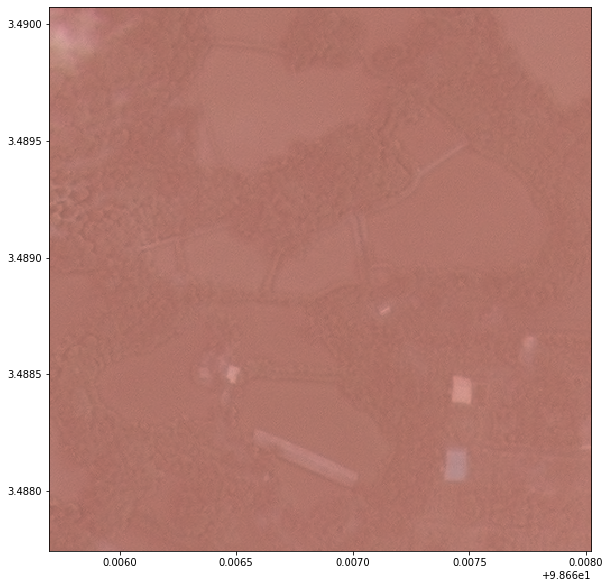

no data ../../data/rasters_waterbodies_osm/cloud_images/Medan_174_pansharpen_True_2020-03-03_04:05_10300100A367E500.tif


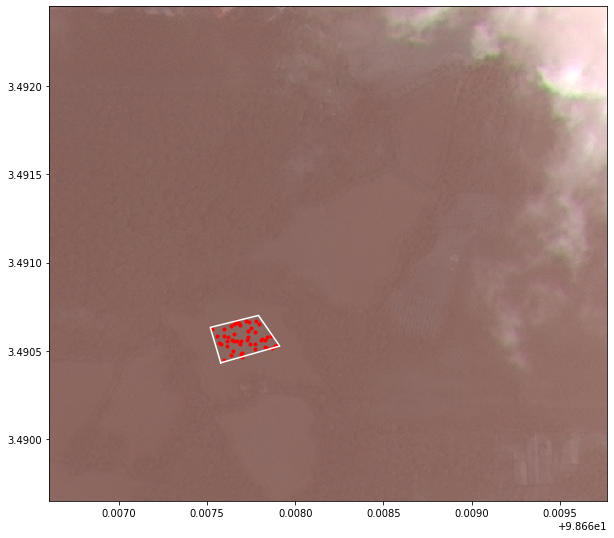

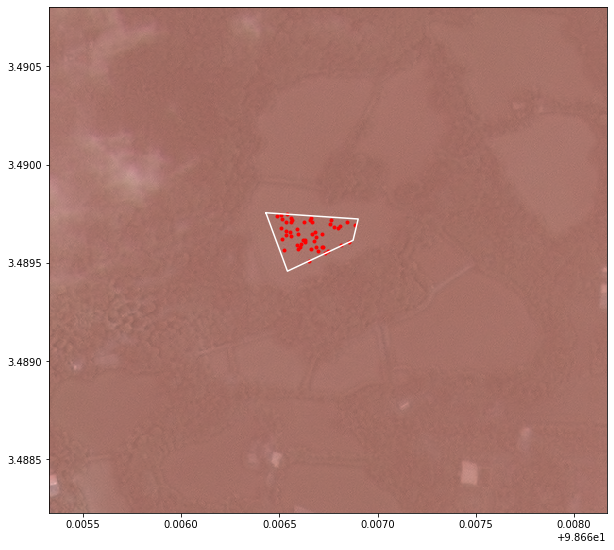

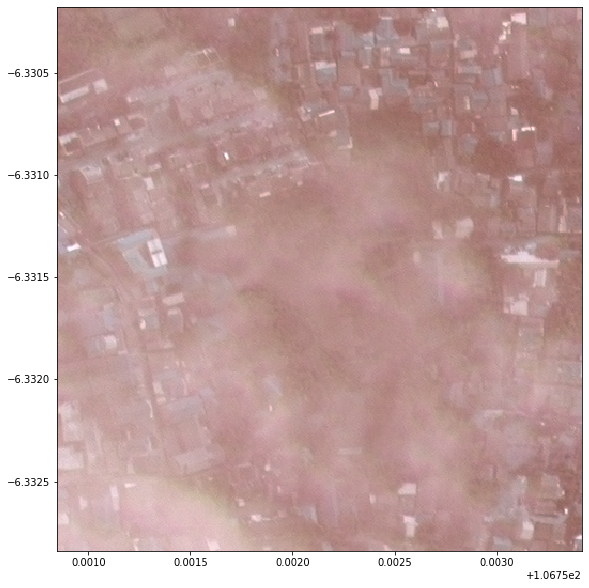

no data ../../data/rasters_waterbodies_osm/cloud_images/Jakarta_580_pansharpen_True_2019-08-05_03:37_10300100990D7100.tif


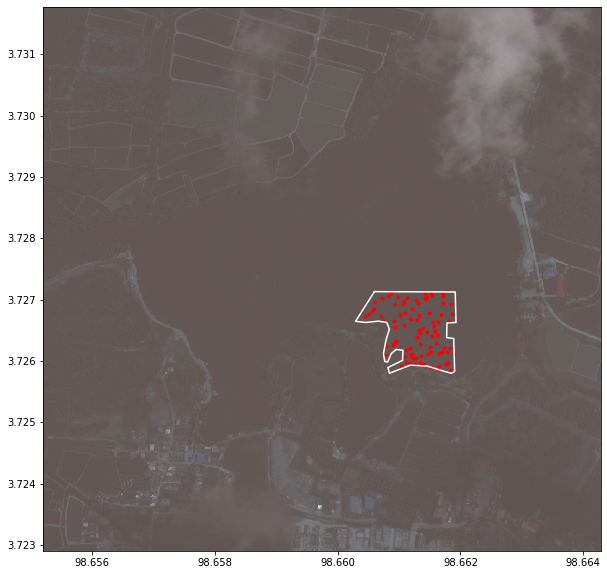

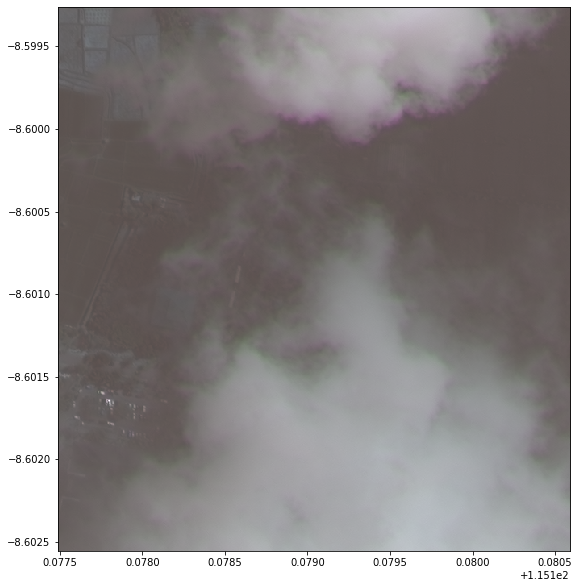

no data ../../data/rasters_waterbodies_osm/cloud_images/Denpasar_030_pansharpen_True_2019-08-06_03:00_103001009813E300.tif


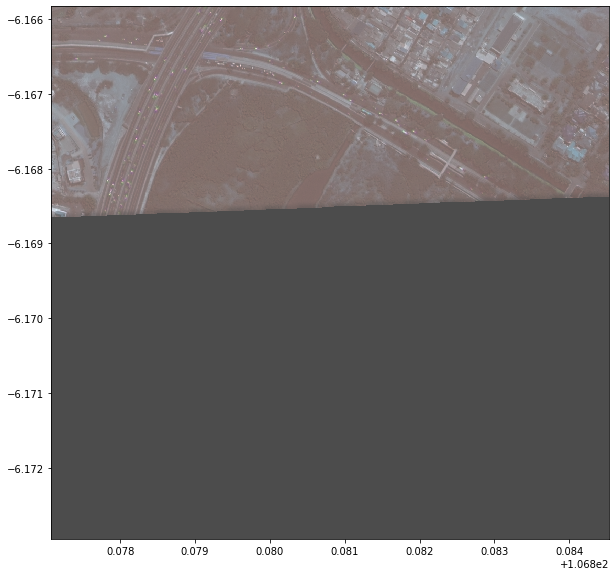

no data ../../data/rasters_waterbodies_osm/cloud_images/Jakarta_002_pansharpen_True_2019-07-23_03:16_1030010096702700.tif


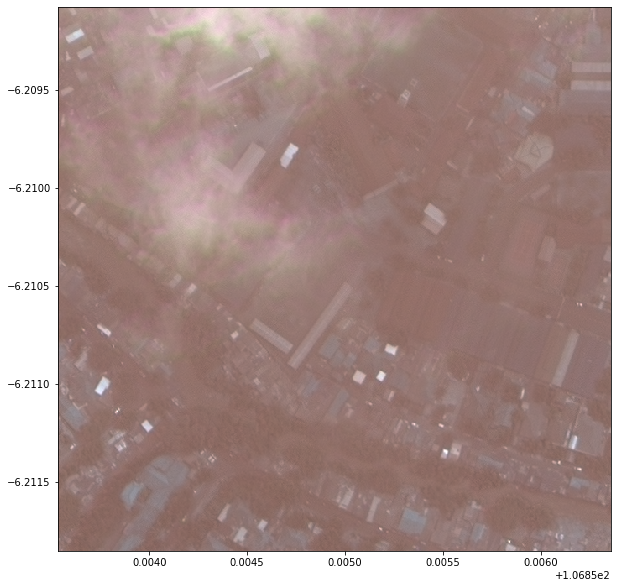

no data ../../data/rasters_waterbodies_osm/cloud_images/Jakarta_385_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.tif


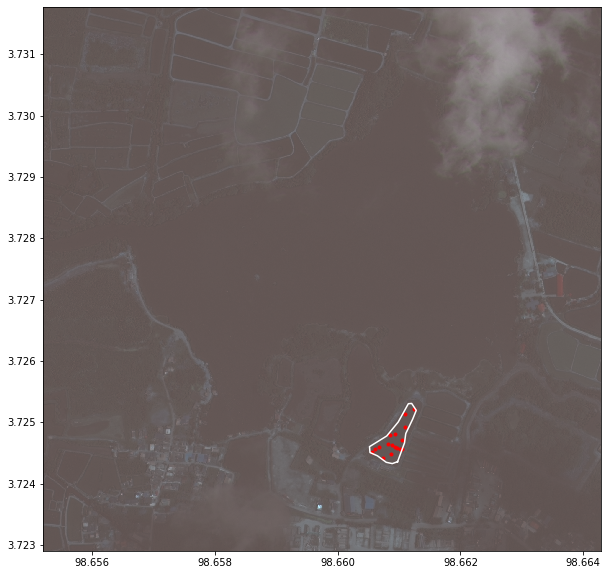

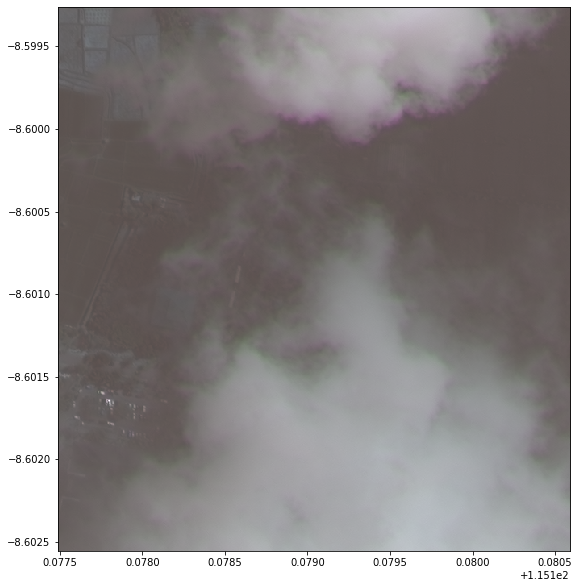

no data ../../data/rasters_waterbodies_osm/cloud_images/Denpasar_030_pansharpen_True_2019-08-06_03:00_103001009813E300.tif



In [55]:
n_points_per_sqkm = 5000
label = 'non_cloud'

df_class1 =  get_data_raster_polygons(class1_MultiPoly[0:10], 
                                      variables, 
                                      image_locations,
                                      raster_files,
                                      plotting_overlap = True)

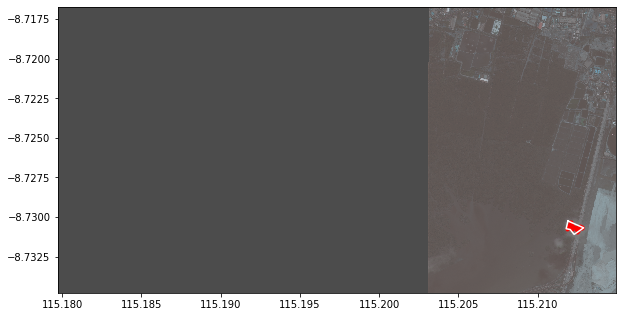

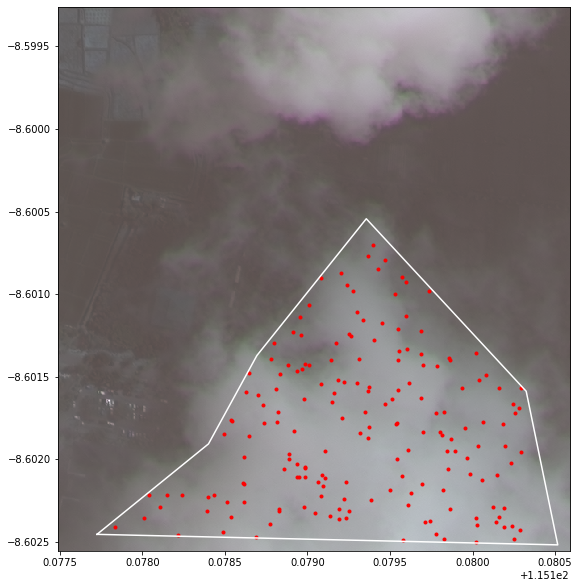

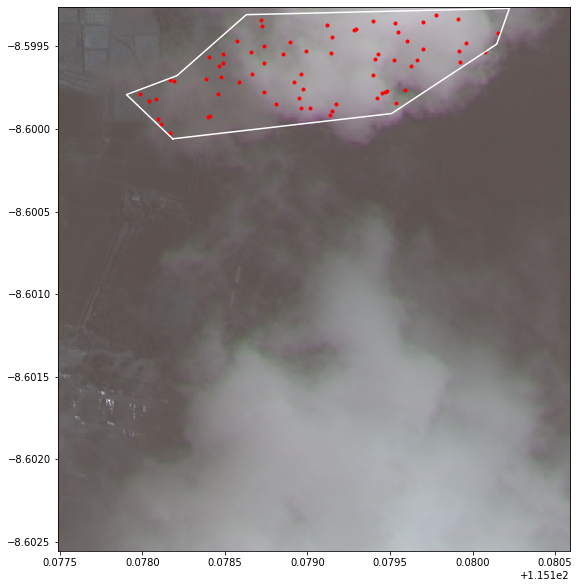

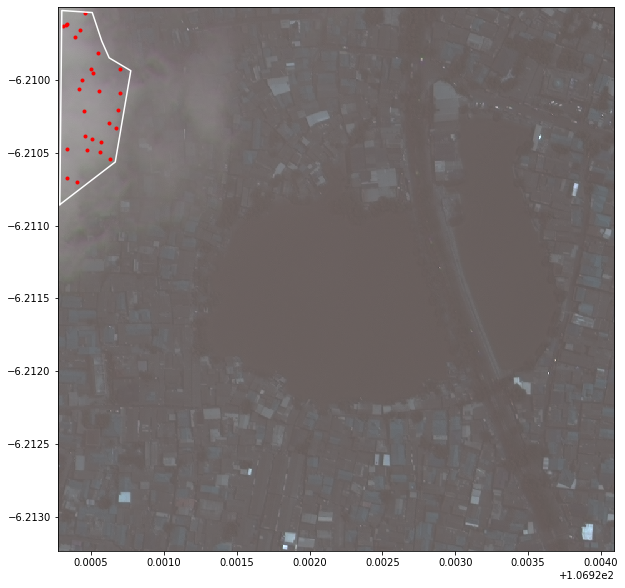

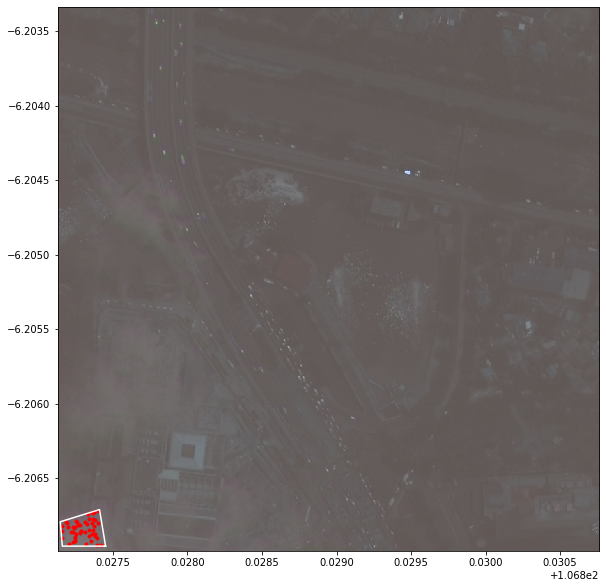

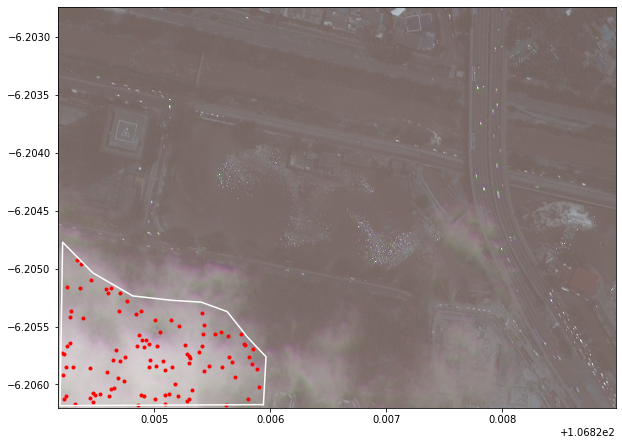

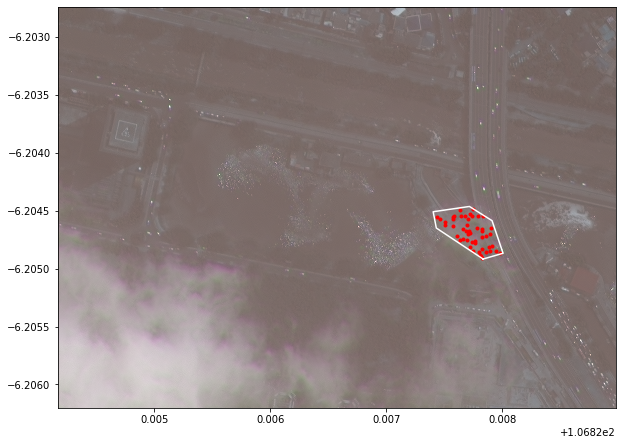

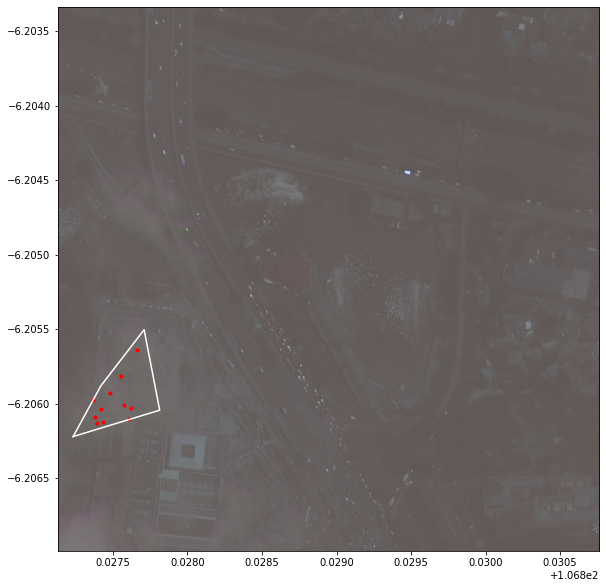

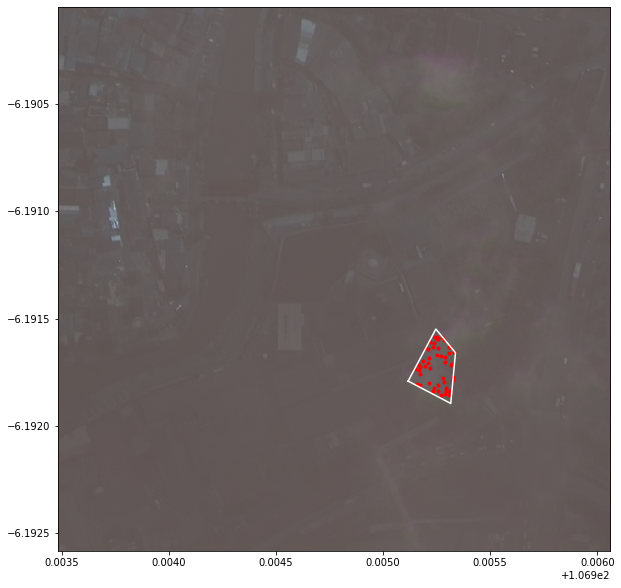

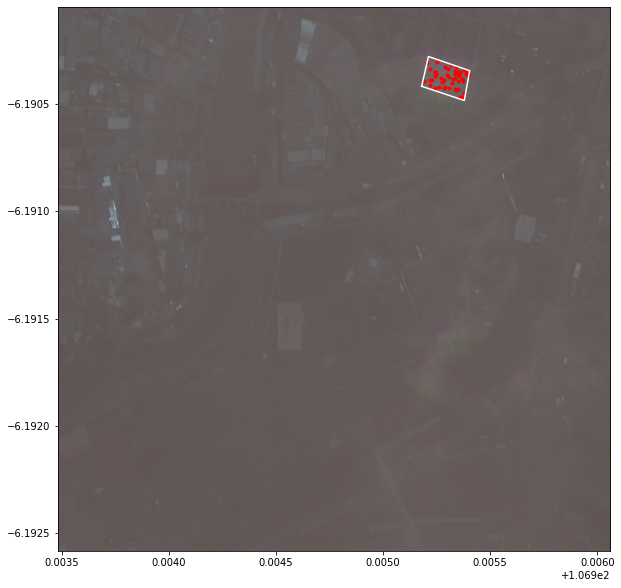

In [56]:
label = 'cloud'

df_class2 =  get_data_raster_polygons(class2_MultiPoly[0:10], 
                                      variables,
                                      image_locations,
                                      raster_files,
                                      plotting_overlap = True)

In [57]:
df_all = df_class1.append(df_class2[0:30000], ignore_index=True)
df_all

0       1       2       3       4       5       6       7  \
0    1665.0  1411.0  1151.0   945.0   858.0   813.0   939.0   661.0   
1    1696.0  1442.0  1182.0   975.0   880.0   845.0   964.0   673.0   
2    1691.0  1434.0  1177.0   970.0   870.0   835.0   951.0   670.0   
3    1687.0  1439.0  1180.0   973.0   873.0   839.0   977.0   679.0   
4    1719.0  1460.0  1195.0   975.0   889.0   848.0   978.0   675.0   
..      ...     ...     ...     ...     ...     ...     ...     ...   
815  2410.0  2276.0  2054.0  1963.0  1924.0  1970.0  2152.0  1865.0   
816  2240.0  2098.0  1880.0  1746.0  1759.0  1716.0  1970.0  1701.0   
817  2414.0  2228.0  1978.0  1924.0  1872.0  1912.0  2095.0  1903.0   
818  2553.0  2392.0  2167.0  2131.0  2065.0  2126.0  2265.0  2032.0   
819  2612.0  2472.0  2248.0  2155.0  2135.0  2141.0  2347.0  2031.0   

              x         y cloudCover  multiResolution  targetAzimuth  \
0     98.667596  3.490449         36         2.158924      50.913406   
1     98.667694  3.490554         36         2.158924      50.913406   
2     98.667649  3.490498         36         2.158924      50.913406   
3     98.667731  3.490614         36         2.158924      50.913406   
4     98.667861  3.490587         36         2.158924      50.913406   
..          ...       ...        ...              ...            ...   
815  106.905220 -6.190335          5         1.898411      67.168434   
816  106.905380 -6.190447          5         1.898411      67.168434   
817  106.905370 -6.190380          5         1.898411      67.168434   
818  106.905283 -6.190386          5         1.898411      67.168434   
819  106.905245 -6.190367          5         1.898411      67.168434   

     sunAzimuth  offNadirAngle  sunElevation  panResolution      label  
0    114.023445      23.307102      64.75944       0.541851  non_cloud  
1    114.023445      23.307102      64.75944       0.541851  non_cloud  
2    114.023445      23.307102      64.75944       0.541851  non_cloud  
3    114.023445      23.307102      64.75944       0.541851  non_cloud  
4    114.023445      23.307102      64.75944       0.541851  non_cloud  
..          ...            ...           ...            ...        ...  
815   62.991226       9.609405      68.11168       0.476140      cloud  
816   62.991226       9.609405      68.11168       0.476140      cloud  
817   62.991226       9.609405      68.11168       0.476140      cloud  
818   62.991226       9.609405      68.11168       0.476140      cloud  
819   62.991226       9.609405      68.11168       0.476140      cloud  

[820 rows x 18 columns]

In [58]:
df_all.sample(10)

0       1       2       3       4       5       6       7  \
200  1588.0  1324.0  1050.0   855.0   781.0   642.0   714.0   494.0   
401  2604.0  2568.0  2541.0  2575.0  2569.0  2808.0  3281.0  2795.0   
169  1590.0  1305.0   997.0   808.0   729.0   640.0   671.0   469.0   
598  4186.0  4251.0  4101.0  4059.0  4108.0  4182.0  4372.0  3956.0   
531  2796.0  2886.0  2661.0  2397.0  2581.0  2478.0  2908.0  2399.0   
339  1926.0  1824.0  1691.0  1588.0  1575.0  1753.0  2216.0  1785.0   
176  1577.0  1296.0   994.0   797.0   726.0   633.0   676.0   461.0   
316  2937.0  2853.0  2832.0  3040.0  2880.0  3296.0  3650.0  3239.0   
355  4114.0  4425.0  4545.0  4693.0  4830.0  4953.0  5521.0  4687.0   
481  1773.0  1696.0  1545.0  1357.0  1399.0  1624.0  2166.0  1768.0   

              x         y cloudCover  multiResolution  targetAzimuth  \
200   98.661049  3.724708         36         2.158924      50.913406   
401  115.180292 -8.601570         24         2.174475     100.732370   
169   98.661416  3.727011         36         2.158924      50.913406   
598  106.824296 -6.205852          5         1.898411      67.168434   
531  106.827265 -6.206814          5         1.898411      67.168434   
339  115.178956 -8.601140         24         2.174475     100.732370   
176   98.661453  3.727050         36         2.158924      50.913406   
316  115.179604 -8.601332         24         2.174475     100.732370   
355  115.179864 -8.602303         24         2.174475     100.732370   
481  115.177984 -8.599787         24         2.174475     100.732370   

     sunAzimuth  offNadirAngle  sunElevation  panResolution      label  
200  114.023445      23.307102     64.759440       0.541851  non_cloud  
401   39.548244      23.735086     57.229374       0.542749      cloud  
169  114.023445      23.307102     64.759440       0.541851  non_cloud  
598   62.991226       9.609405     68.111680       0.476140      cloud  
531   62.991226       9.609405     68.111680       0.476140      cloud  
339   39.548244      23.735086     57.229374       0.542749      cloud  
176  114.023445      23.307102     64.759440       0.541851  non_cloud  
316   39.548244      23.735086     57.229374       0.542749      cloud  
355   39.548244      23.735086     57.229374       0.542749      cloud  
481   39.548244      23.735086     57.229374       0.542749      cloud

In [59]:
df_all.groupby('label').count()[0]

label
cloud        612
non_cloud    208
Name: 0, dtype: int64

# Export training data

In [16]:
df_all.label.unique()

array(['non_cloud', 'cloud'], dtype=object)

In [30]:
import datetime

file_name = 'all_polygons'

NOW = datetime.datetime.now()

csv_filename = "../../data/trainings_data_waterbodies/cloud_data_non_acomp_{}_{}.csv".format(file_name, NOW)

csv_filename

'../../data/trainings_data_waterbodies/cloud_data_non_acomp_all_polygons_2020-04-23 11:28:33.042623.csv'

In [31]:
df_all.to_csv(csv_filename)

print('data written to file')

data written to file


# In case of emergency

In [54]:
# Save dataframe as csv file and create download link
from IPython.display import HTML
import base64  
import pandas as pd  
import datetime

NOW = datetime.datetime.now()

def create_download_link(df, title = "Download CSV file", 
                         filename = "data_{}_{}.csv".format(file_name, NOW)):  
    
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)

# all pixels method

In [467]:
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

dataset = rasterio.open(path_match_image)
bands,x,y = dataset.read().shape
array_dataset = dataset.read().reshape([x*y,8])

In [468]:
rasterio.__version__

'1.1.0'

In [499]:
water_pixels_mask = mask(dataset, [water_Multi[0]],invert = False, crop = False)[0]

b,x,y = water_pixels_mask.shape

water_pixels = water_pixels_mask.reshape([x*y,8])[:,0].astype(int)

water_pixels = water_pixels != 0

sum(water_pixels) / len(water_pixels)

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/rasterio/mask.py:92: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


0.0

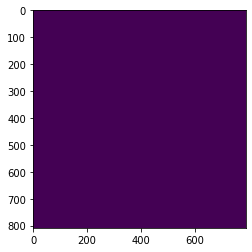

In [500]:
plt.imshow(water_pixels_mask[1,:,:])

In [480]:
# Create dataframe from clicked values

import pandas as pd

df_bands = pd.DataFrame(array_dataset)

df_bands['label'] = 'non_water'
df_bands.loc[water_pixels, ['label']] = 'water'

In [481]:
sum(df_bands.label == 'water')

5120

In [482]:
sum(df_bands['label'] == 'water') + sum(df_bands['label'] == 'non_water')

638320

In [483]:
df = df_bands

# Visualizations

In [ ]:
## check data!!
# !pip install folium


import folium


m = folium.Map([water_Multi_wgs.centroid.y, water_Multi_wgs.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB') #, name = 'cartocdn')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


folium.Choropleth(water_Multi, name = 'Training set water').add_to(m)

folium.Choropleth(non_water_Multi_wgs, name = 'Training set water').add_to(m)


# folium.Choropleth(setu_smooth, name = 'Smooth setu delineation').add_to(m)



# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 


# I can add marker one by one on the map
# for i in range(0,len(data)):
#     folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)

for point in points_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x]).add_to(m)
    
    
for point in points_non_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x]).add_to(m)

folium.LayerControl().add_to(m)


In [ ]:
# view folium map

# m

In [ ]:
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:4326'))


non_water_Multi_wgs = transform(project, non_water_Multi)
water_Multi_wgs = transform(project, water_Multi)

non_water_Multi_wgs